# Bibliotecas

In [2]:
#Bibliotecas
from shapely import LineString, Point, Polygon
import shapely as sh
import matplotlib.pyplot as plt
from random import uniform
import numpy as np
import scipy

#Para paralelizar
import threading as th
from multiprocessing import Process
import os
import time

# Funciones

## Funciones auxiliares

Aquí se encuentran las funciones que no tienen procedimientos tan extensos, si no que 
se han hecho para ser llamadas por las funciones principales

In [3]:
#Funciones

def distancia_de_un_punto_a_otros(zz,punto):
    """
    zz    -> Arreglo numpy de dimensiones(N,2)
    punto -> coordenadas de un punto (x,y)
    """
    
    z= np.array(zz,copy=True)
    #Ahora encontraremos la distancia minima
    distancia_minima = 1000

    for i in range(0,len(zz)):
        
            #Calculamos la distancia entre el punto i y el punto j
            distancia =   Point(z[i,0],z[i,1]).distance(Point(punto[0],punto[1]))
            
            #Si la distancia calculada es menor a la distancia minima entonces la actualizamos y si 
            #es la primera comparacion esa es la distancia minima
            if distancia_minima>distancia:
                distancia_minima = distancia

    return distancia_minima

#Funciones

def distancia_de_un_punto_a_otros_identificador(zz,punto):
    """
    zz    -> Arreglo numpy de dimensiones(N,2)
    punto -> coordenadas de un punto (x,y)
    
    Se regresan dos resultados
    distancia_minima -> Float64
    indice -> Indice de cual fue el elemento del arreglo zz
              con el que se encontro la distancia minima
    """
    
    z= np.array(zz,copy=True)
    #Ahora encontraremos la distancia minima
    distancia_minima = 1000
    indice = 0
    for i in range(0,len(zz)):
        
            #Calculamos la distancia entre el punto i y el punto j
            distancia =   Point(z[i,0],z[i,1]).distance(Point(punto[0],punto[1]))
            
            #Si la distancia calculada es menor a la distancia minima entonces la actualizamos y si 
            #es la primera comparacion esa es la distancia minima
            if distancia_minima>distancia:
                distancia_minima = distancia
                indice = i

    return distancia_minima, indice


def distancia_minima_todos_puntos(zz,indice_max):
    z= np.array(zz,copy=True)
    #Ahora encontraremos la distancia minima
    distancia_minima = 1000

    for i in range(0,indice_max):
        for j in range(0,indice_max):
            #No se compara la distancia entre puntos iguales
            if i==j:
                break
            #Calculamos la distancia entre el punto i y el punto j
            #distancia = ((z[i,0] - z[j,0])**2 + (z[i,1] - z[j,1])**2)**0.5
            distancia =   Point(z[i,0],z[i,1]).distance(Point(z[j,0],z[j,1]))
            #Si la distancia calculada es menor a la distancia minima entonces la actualizamos y si 
            #es la primera comparacion esa es la distancia minima
            if distancia_minima>distancia and (distancia != 0):
                distancia_minima = distancia

    return distancia_minima

def identificador_cero(zz):
    z= np.array(zz,copy=True)
    for i in range(0,len(z)):
        if (z[i,0] == 0) and (z[i,1]==0):
            break
    
    return i

#Esta funcion genera las rectas para graficar no para saber que valores tiene esa recta

def f(x,a,b):
    y=0
    xx = np.array(x,copy=True)
    y = a*xx + b
    return y


## Funciones secundarias
Estas funciones tienen como común denominador que:
 -  Tienen uno o varios ciclos en su interior
 -  Son procesos largos que si estuvieran en un solo
     segmento de código se volverían muy dificil de
     de

In [87]:

#Esta funcion tiene como objetivo calcular las pendientes de multiples rectas 
#en las que cada una pasa sobre dos puntos

def calcular_las_semirectas(arreglo):
    """
    El arreglo que se recibe debe de tener el siguiente formato 
    arreglo :   Dimensiones ->  (ranglones  ,  filas)
                                (N_renglones,2_filas)
                Valores_recibidos ->  [[coord_x, coord_y), (coord_x1,coord_y1),...]
    Se regresará un arreglo con el siguiente formato
    m       :   Dimensiones ->  (ranglones         ,filas)
                                (cantidad_de_Rectas,    6)
                Valores_en_cada_renglon ->   (pendiente, ordenada_origen,
                                                limitex_inferior, limitex_superior
                                                limitey_inferior, limitey_superior)
                
    """
    arreglo_u = np.array(arreglo, copy=True)
    
    #La cantidad de rectas que se van a calcular depende de la cantidad de puntos
    if len(arreglo_u) == 2:
        cantidad_de_rectas = 1
    else:
        cantidad_de_rectas = len(arreglo_u) - 1

        
    rectas = np.zeros((cantidad_de_rectas,6),np.float64)
    
    #Se calcularan las normales 
    for i in range(0,len(rectas)):
        #Hacemos un filtro para comprobar que los puntos 
        #no puedan estar uno sobre otro y no obtendremos un error matematico
        #o un valor gigantesco
        
        #rectas[,0] = np.nan significa que hay infinitos valores y
        #rectas[,0] = np.inf es que hay infinitos valores de x      
        #Caso en el que hay infinitos valores de y para una funcion
        if abs(arreglo_u[i,0] - arreglo_u[i+1,0])<0.000001:
            rectas[i,:] = (np.nan,np.inf,arreglo[i,0],arreglo[i+1,0],arreglo[i,1],arreglo[i+1,1])
            

            continue
        #Caso en el que hay infinitos valores x para una funcion
        elif abs(arreglo_u[i,1] - arreglo_u[i+1,1])<0.000001:
            rectas[i,:] = (np.inf,np.nan,arreglo[i,0],arreglo[i+1,0],arreglo[i,1],arreglo[i+1,1])
            continue
            
        #Caso regular
        else:
            p = np.polyfit(
                        arreglo_u[i:i+2,0],
                        arreglo_u[i:i+2,1],
                        1)
            rectas[i,:] = (p[0],p[1],arreglo[i,0],arreglo[i+1,0],arreglo[i,1],arreglo[i+1,1])
        
    return rectas

def vector_director(m1,b1):
    
    #Calculamos dos puntos de cada recta
    x1=1
    x2=2
    P1 = [x1, f(x1,m1,b1)]
    P2 = [x2, f(x2,m1,b1)]
    vector_dire = [P2[0] - P1[0], P2[1] - P1[1]]
    
    #Normalizamos el vector director
    magnitude = (vector_dire[0]**2 + vector_dire[1]**2)**0.5
     
    
    vector_dire = [vector_dire[0]/magnitude, vector_dire[1]/magnitude]
    if np.isinf(m1):
        vector_dire = [1,0]
    elif np.isnan(m1):
        vector_dire = [0,1]
        
    return np.array(vector_dire)

def pts_vecindad(arr,pt_c,h):
    """
    Objetivo: El objetivo de la funcion es encontrar todos los puntos (x,y) que se encuentran dentro de 
    una vecindad circular con cierto radio R y regresar los indices correspondientes 
    
    Datos de entrada:
        arr:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        N,       2)
                                N es un numero entero deseado
        pt_c:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2)
        h:
            Variable tipo flotante
    Datos de salida:
        indices_arr:
            Arreglo tipo numpy con tipo de dato np.float64
            Dimensiones   ->    (renglones,columnas)
                                (        M,       1)
                                M es la canatidad de indices que la funcion encuentre
                                dentro de la vecindad
    nota: Se espera que una futura implementación permita tambien reducir la cantidad de calculos
          tomando encuenta que un pt1 ya se encuentra en la vecindad de otro pt2, por lo que pt2
          es parte de la vecindad de pt1
          
    """
    arr_u = np.array(arr,copy=True)
    N = len(arr_u)
    
    indices_arr = np.zeros((N,1),np.float64)
    
    #Cuenta cuantos pts caen dentro de la vecindad
    cont_in_h = 0
    
    
    for i in range(0,N):
        
        #Observamos que no haya dos puntos iguales mas de dos veces, por que si hay dos puntos iguales
        #mas de dos veces tenemos un error en nuestro filtrado de puntos en el poligono
        
        
        #Observamos si la distancia entre los puntos pt_c, y arr_u[i] es menor que
        #el radio de la vecindad y 
        distance = Point(pt_c[0],pt_c[1]).distance(Point(arr_u[i,0],arr_u[i,1]))
        if (h > distance) and (distance!=0.0):
            #Si es menor entonces guardamos el indice y aumentamos el contador
            indices_arr[cont_in_h,0] = i
            cont_in_h +=1
        elif distance==0.0:
            continue
            
    #Regresamos un indice con esos datos y solo esos datos
    return indices_arr[:cont_in_h]

def vecindad_paralelo_proceso(h,N_f,pts_vec,pt_g_u):
    
    return


def vecindad_paralelo_estructura(h,N_f,pts_vec,pt_g_u):
   

    # Para observar la ejecucion debemos de ejecutar en una consola
    # y colocamos el main para facilitar todo

    if __name__ == '__main__':
        #En esta lista se guardaran los hilos
        hilos = []
        
        cores = os.cpu_count()
        print("Tienes", cores, "cores")

        print("Se crean los hilos")
        #El numero de hilos sera segun el numero de cores q tengamos
        
        #Aquí se calculara el numero de 
        diferencia = round(N_f/cores)
        for n in range(cores):
                
                startin =n*diferencia + (n>0)
                finalin =(n+1)*diferencia
                hilo = Process(target = funcion, args=())
                #Los adicionamos a la lista de procesos
                hilos.append(hilo)

        print("Los hilos empezaran a ejecutarse")
        for hilo in hilos:
                hilo.start()
        
        print("------espera?")

        
        for hilo in hilos:
                hilo.join() #Se bloquea la ejecucion del formato principal
                            #hasta que se acaben de ejecutar los hilos
                print("hilo:", hilo)
        
        print("Regreso a la ejecucion inicial")
        time.sleep(1)
    
    return

def C_matrix_normal(sum_M,arr_u,pt_c_u,f,delta=1):
    """
    Objetivo: Llevar acabo la suma de matrices dada por la ecuacion
    #La ecuacion que generara cada una de las matrices es
    #    ----
    #    \   (r_j - r_i)(r_j - r_i)^T
    # C = -    ---------------------    w_(i,j)
    #    /       ||r_j - r_i||^2
    #    ----
    #      j
    # Donde las r_j representa a todos los puntos circundantes
    # y la sumatoria va rondando en ellos, no se calcula a si mismo
    
    y regresar solo la suma de todas las matrices generadas
    
        Datos de entrada:
        sum_M:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            Objetivo      ->    donde se guardara la suma de matrices               
        
        arr_u:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        N,       2)
                                N es un numero entero deseado
            objetivo      ->    donde se guardaran los puntos (x,y) circundantes
                                al punto central, así que estos deben ser filtrados 
                                con anterioridad a la función.
                                Un punto (x,y) por cada renglon
        pt_c_u:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2)
            objetivo      ->    donde se guardaran las coordenadas (x,y)
                                del punto central en el que se estan llevando acabo
                                las operaciones para encontrar su normal
        f:
            String
            Opciones permitidas: "Gaussian","Inverse","Polynomal","Identity","Laplacian","Cousine"
            objetivo      ->    Decir que función de peso se usará para
                                calcular cada una de las matrices que se sumara
                                
    Dato de salida:
        sum_M:
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            objetivo      ->    Ser ya la suma de todas las matrices que calculamos
    """
    #Lo del vector transpuesto no funciona como deberia aveces, así que hay
    #que asegurarse o hacer una funcion especifica aparte, para generar la matrix
    # de 2x2
    dif_ij = np.zeros((1,2),np.float64)
   
    
    #Eleccion de funcion de peso
#--------------------------------------------------------------------------------------------------------------
    #Nota_ CALCULAR LA DELTA 
#--------------------------------------------------------------------------------------------------------------
    if f == "Gaussian":
        f = "(1/(delta*(2*np.pi)**0.5))*np.exp(-((magnitude2**0.5)-promedio)**2/(2*delta**2))"
    
    """
    Vamos a calcular la delta que es la des estandar, para eso:
    1 primero encontraremos todas las disntancias
      entre nuestro punto y los demas
    
    2 Sacamos la desviacion estandar con una funcion de numpy
    """
    #Variable para tener todas las magnitudes 
    mag_arr = np.zeros((len(arr_u),1),np.float64)
    #Identificador del indice que nos da el punto que sera igual
    identificador = 0
    
    #Arreglo que calculara la diferencia de posiciones
    #entre los vectores y nuestro pt
    for i in range(0,len(arr_u)):
        if (arr_u[i,0]==pt_c_u[0]) and (arr_u[i,1]==pt_c_u[1]):
            identificador = i
            continue
        dif_ij = arr_u[i,:] - pt_c_u
        mag_arr[i] = ((dif_ij[0])**2+(dif_ij[1])**2)**0.5
    
    #Eliminamos el que no tiene nada por que seria la distancia
    #consigo mismo
    mag_arr = np.delete(mag_arr,(identificador),axis=0)
    
    #Calculamos la delta
    delta = np.std(mag_arr)
    promedio = np.mean(mag_arr)
    #Por como guardamos los puntos la transpuesta es la normal y viceversa
    #pero se sigue el mismo procedimiento descrito arriba
    for j in range(0,len(arr_u)):
        
        #La siguiente condicion se asegura de que no se saque la diferencia
        #de vectores, siendo ambos vectores los mismos
        if (arr_u[j,0]==pt_c_u[0]) and (arr_u[j,1]==pt_c_u[1]):
            continue
        
        
        #Se saca la diferencia entre vectores posicion
        dif_ij = arr_u[j,:] - pt_c_u
        #Se saca la magnitud de la diferencia entre los vec_posicion
        magnitude2 = ((dif_ij[0])**2+(dif_ij[1])**2)

        #Se suma a la matriz resultante la nueva matriz
        elemento_00 = dif_ij[0]**2
        elemento_11 = dif_ij[1]**2
        elemento_01_10 = dif_ij[0]*dif_ij[1]
        f_eval = eval(f)
        sum_M[0,0] +=  ((elemento_00)/(magnitude2))*f_eval
        sum_M[1,1] +=  ((elemento_11)/(magnitude2))*f_eval
        sum_M[0,1] +=  ((elemento_01_10)/(magnitude2))*f_eval
        sum_M[1,0] +=  ((elemento_01_10)/(magnitude2))*f_eval
        

        #sum_M +=  ((np.transpose(dif_ij)*dif_ij)/(magnitude2))*f_eval
        
    return sum_M

def C_eigen_ponderado(sum_M,pt_c_u,Figura):
    """
    C_eigen_normal donde calcularemos los eigenvalores e eigenvectores 
    y obtendremos el eigenvalor minimo y su eigenvector correspondiente 
    que debe ser el normal
    """
    """
    Objetivo_General:
    
    C_eigen_ponderado donde aparte de obtener los eigenvalores e eigenvectores, 
    veremos que estos no esten apuntando dentro de la figura, si lo estan
    modificamos su direccion por un factor -1.  Despues tomamos ambos eigenvectores 
    y según su eigenvalor ponderamos un vector promedio ponderado 
    y ese será el vector normal al punto
    
    Datos de entrada:
        sum_M:
            Arreglo tipo numpy 
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            Objetivo      ->    Que se le de una matriz 2x2
                                con diferentes valores
        pt_c_u:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2) 
            Objetivo      ->    Tener como referencia a que punto correspondera
                                el eigevector con el eigenvector minimo
        Figura:
            Classe tipo Polygon
            Objetivo      ->    Saber si los eigenvectores apuntan para 
                                afuera o para adentro
    Datos de salida:
        normal_vec_: eig_1 or eig_2
            Dimensiones    ->    (renglones,columnas)
                                 (       1,        2)
            Objetivo       ->    Saber la direccion a la que apunta 
                                 la normal obtenida
                                 
        pt_c_u:
            Solo saber a que punto pertenece y así tener más control de la funcion
            que estamos aplicando, en un futuro puede ser eliminado, todo depende de la
            implementacion de otras funciones
     """
    
    #Con la matriz 2x2 recibida solo tenemos que  encontrar sus eigenvalores e eigenfunciones
    Eigen_data = np.linalg.eig(sum_M)
    
    #Esta solo encuentra los eigenvalores para comprobar
    R_v = scipy.linalg.eigvals(sum_M)
    
    #Renombramos el arreglo para hacer un mejor manejo de los datos
    R = Eigen_data
    #Ahora sacamos los eigenvectores a la forma en que nosotros estamos
    #guardando un vector desde el principio
    #Eigenvectores
    
    #Queremos reconocer que indice de eigenvalor corresponde
    #a q indice de eigenvector y como solo ex una matriz de 2x2
    #si un eigenvalor no corresponde a eig_vec 1 corresponde al dos
    #así de simple
    eig_1 = np.array([R[1][0][0],R[1][1][0]])
    eig_2 = np.array([R[1][0][1],R[1][1][1]])
    #print(eig_1)
    #Con el siguiente código se comprueba que eigenvalor esta
    #asocidado a cada eigenvector con la ecuacion de eigenvalores y eigenvectores
    # R_v[0]*n = sum_M*n ----------------------------------------------------------------------------------[ec1]
    
    #En las siguientes variables se guardara la multiplicacion
    #de la matrix con el eigenvector correspondiente
    x=0
    y=0
    z=0
    for i in range(0,2):
        x += sum_M[0][i]*eig_1[i]
        y += sum_M[1][i]*eig_1[i]
    
    #Ahora elegimos el eigenvalor más pequeño que es el que queremos
    #encontrar y según cual sea regresaremos el eigenvector correspondiente
    # y el punto 

    
    #Esta variable guardara el menor valor de una sola vez para
    #poder ya trabajar con el eigenvalor menor
    eig_valor = R_v[1]*(R_v[0]>R_v[1]) + R_v[0]*(R_v[1]>R_v[0])
            
    #Creamos la derecha e izquierada de la ec1
    izq_ecuacion = np.around((eig_valor*np.array(eig_1)).real,5)
    der_ecuacion = np.round(np.array([x,y]),5)

    #Si son iguales regresaremos ese eigen_vector, pero
    #ya puesto para que apunte fuera de la figura y si no
    #regresamos el otro
    if (der_ecuacion == izq_ecuacion).all() == True:
        
        #Obtenemos el eigenvector_ponderado
        eig_pon = (eig_1*abs(eig_valor) + eig_2*abs((R_v[1]*(R_v[0]<R_v[1]) + R_v[0]*(R_v[1]<R_v[0])))/(R_v[0]+R_v[1]))
        eig_pon = eig_pon/(eig_pon[0]**2 + eig_pon[1]**2 )**0.5 
        #Comprobación de si apunta dentro o fuera
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        
        
        x_final =float( eig_pon[0]*0.001 + pt_c_u[0])
        y_final =float( eig_pon[1]*0.001 + pt_c_u[1])
        
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            eig_pon *=-1
            
        return eig_pon,pt_c_u
    else:
       
        eig_pon = (eig_2*abs(eig_valor) + eig_1*abs((R_v[1]*(R_v[0]<R_v[1]) + R_v[0]*(R_v[1]<R_v[0])))/(R_v[0]+R_v[1]))
        eig_pon = eig_pon/(eig_pon[0]**2 + eig_pon[1]**2 )**0.5   
        #print(eig_valor)
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        
        x_final = float(eig_pon[0]*0.001 + pt_c_u[0])
        y_final = float(eig_pon[1]*0.001 + pt_c_u[1])
             
        
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            #print("antes",eig_2)
            eig_pon = eig_pon*-1
            #print(eig_2)
            #print("Eigens:",eig_2,"   ",eig_1)
            
            return eig_pon,pt_c_u
        
        return eig_pon,pt_c_u
    
    
    print("FALLLO CRITICO LA FUNCION NO HA CUMPLIDO EL OBJETIVO")
    return None
    pass

def C_eigen_normal(sum_M,pt_c_u,Figura):
    """
    Objetivo_General:
    
    C_eigen_ponderado donde aparte de obtener los eigenvalores e eigenvectores, 
    veremos que estos no esten apuntando dentro de la figura, si lo estan
    modificamos su direccion por un factor -1.  Despues tomamos ambos eigenvectores 
    y según su eigenvalor ponderamos un vector promedio ponderado 
    y ese será el vector normal al punto
    
    Datos de entrada:
        sum_M:
            Arreglo tipo numpy 
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            Objetivo      ->    Que se le de una matriz 2x2
                                con diferentes valores
        pt_c_u:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2) 
            Objetivo      ->    Tener como referencia a que punto correspondera
                                el eigevector con el eigenvector minimo
        Figura:
            Classe tipo Polygon
            Objetivo      ->    Saber si los eigenvectores apuntan para 
                                afuera o para adentro
    Datos de salida:
        normal_vec_: eig_1 or eig_2
            Dimensiones    ->    (renglones,columnas)
                                 (       1,        2)
            Objetivo       ->    Saber la direccion a la que apunta 
                                 la normal obtenida
                                 
        pt_c_u:
            Solo saber a que punto pertenece y así tener más control de la funcion
            que estamos aplicando, en un futuro puede ser eliminado, todo depende de la
            implementacion de otras funciones
     """
    
    #Con la matriz 2x2 recibida solo tenemos que  encontrar sus eigenvalores e eigenfunciones
    Eigen_data = np.linalg.eig(sum_M)
    
    #Esta solo encuentra los eigenvalores para comprobar
    R_v = scipy.linalg.eigvals(sum_M)
    
    #Renombramos el arreglo para hacer un mejor manejo de los datos
    R = Eigen_data
    #Ahora sacamos los eigenvectores a la forma en que nosotros estamos
    #guardando un vector desde el principio
    #Eigenvectores
    
    #Queremos reconocer que indice de eigenvalor corresponde
    #a q indice de eigenvector y como solo ex una matriz de 2x2
    #si un eigenvalor no corresponde a eig_vec 1 corresponde al dos
    #así de simple
    eig_1 = np.array([R[1][0][0],R[1][1][0]])
    eig_2 = np.array([R[1][0][1],R[1][1][1]])
    #print(eig_1)
    #Con el siguiente código se comprueba que eigenvalor esta
    #asocidado a cada eigenvector con la ecuacion de eigenvalores y eigenvectores
    # R_v[0]*n = sum_M*n ----------------------------------------------------------------------------------[ec1]
    
    #En las siguientes variables se guardara la multiplicacion
    #de la matrix con el eigenvector correspondiente
    x=0
    y=0
    z=0
    for i in range(0,2):
        x += sum_M[0][i]*eig_1[i]
        y += sum_M[1][i]*eig_1[i]
    
    #Ahora elegimos el eigenvalor más pequeño que es el que queremos
    #encontrar y según cual sea regresaremos el eigenvector correspondiente
    # y el punto 

    
    #Esta variable guardara el menor valor de una sola vez para
    #poder ya trabajar con el eigenvalor menor
    eig_valor = R_v[1]*(R_v[0]>R_v[1]) + R_v[0]*(R_v[1]>R_v[0])
    #print(eig_valor)
    #Creamos la derecha e izquierada de la ec1
    izq_ecuacion = np.around((eig_valor*np.array(eig_1)).real,5)
    der_ecuacion = np.round(np.array([x,y]),5)

    #Si son iguales regresaremos ese eigen_vector, pero
    #ya puesto para que apunte fuera de la figura y si no
    #regresamos el otro
    if (der_ecuacion == izq_ecuacion).all() == True:
        #print(eig_valor)    
        #Comprobación de si apunta dentro o fuera
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        x_final = eig_1[0]*0.001 + pt_c_u[0]
        y_final = eig_1[1]*0.001 + pt_c_u[1]
        print("igual")
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            eig_1 *=-1
            
        return eig_1,pt_c_u
    else:
        
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        
        x_final = eig_2[0]*0.001 + pt_c_u[0]
        y_final = eig_2[1]*0.001 + pt_c_u[1]
        print("dif")      
        
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            #print("antes",eig_2)
            eig_2 = eig_2*-1

            return eig_2,pt_c_u
        
        return eig_2,pt_c_u
    
    
    print("FALLLO CRITICO LA FUNCION NO HA CUMPLIDO EL OBJETIVO")
    return None
    

def normal_metodo_optimizacion(pts_nhd,pt_c,f,Figura,metodo):
    """
    Objetivo: Se busca poder calcular la normal de los puntos de un poligono
    por medio del metodo de optimizacion presentado en el articulo
    del profesor Félix
    
    Datos de entrada:
        arr:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        N,       2)
                                N es un numero entero deseado
        pt_c:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2)
        f:
            String
            Opciones permitidas: "Gaussian","Inverse","Polynomal","Identity","Laplacian","Cousine"
        
        Figura:
            Classe Polygon 
            Objetivo       -> Ayudarnos a saber que el eigenvector que sera el normal
                              apunta hacia afuera
    
    Dato de salida:
        Normal:
            Dimensiones   ->    (renglones,columnas)
                               (        1,       4)
            Se busca que este dato sea el vector normal al punto ya normalizado (x1,y1,x2,y2)
            donde x1,y1 representen donde inicia y x2y2 donde termina
    """
    #Como podriamos modificar los valores, no queremos que haya problemas
    arr_u = np.array(pts_nhd, copy=True)
    pt_c_u =  np.array(pt_c, copy=True)
#     
    #Aquí guardaremos la suma de todas las matrices generadas
    sum_M =np.zeros((2,2),np.float64)
    
    #Aqui guardaremos la magnitud al cuadrado de la diferencia entre los vectores
    magnitude2 = 0
    
    #Aqui guardaremos el vector diferencia transpuesto
    
    #Lo del vector transpuesto no funciona como deberia aveces, así que hay
    #que asegurarse o hacer una funcion especifica aparte, para generar la matrix
    # de 2x2
    dif_ij = np.zeros((1,2),np.float64)
    
    #La ecuacion que generara cada una de las matrices es
    #    ----
    #    \   (r_j - r_i)(r_j - r_i)^T
    # C = -    ---------------------    w_(i,j)
    #    /       ||r_j - r_i||^2
    #    ----
    #      j
    # Donde las r_j representa a todos los puntos circundantes
    # y la sumatoria va rondando en ellos, no se calcula a si mismo
    
    sum_M = C_matrix_normal(sum_M,arr_u,pt_c_u,f,dif_ij)
    
    #Ahora sacamos el eigenvector util y elegimos el metodo que queremos
    
    if metodo == 0:
        Eigen_data_data = C_eigen_normal(sum_M,pt_c_u,Figura)
    elif metodo == 1:
        Eigen_data_data = C_eigen_ponderado(sum_M,pt_c_u,Figura)
    #print(Eigen_data_data)
    #Ya con el eigenvector normal ya devolvemos la informacion que queremos
    return Eigen_data_data[0]

# Figura

Lo que buscamos aquí es ordenar los puntos de la siguiente forma:

    - Dar un arreglo
    - Generar un arreglo vacio de las mismas dimensiones
    - Elegir un elemento de ese arreglo
    - Guardar ese elemento en la primera parte del arreglo en ceros
    - Calcular cual es el siguiente punto más cercano a ese
    - Guardar ese punto en el siguiente indice del arreglo en ceros
    - Eliminar el punto del arreglo original

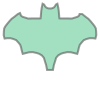

In [6]:
Puntos_sin_ordenar = [(0.398800723842904, -7.95365259525281), (3.68659254979499, -5.78561595640035), (0.517923616087545, -7.31038897713175), (0.684695665230042, -6.78624825125533), (0.827643135923611, -6.30975668227677), (1.11353807731075, -5.97621258399178), (1.49473133249360, -5.76179137795142), (1.87592458767645, -5.64266848570678), (2.35241615665501, -5.54737017191107), (2.85273230408251, -5.57119475036000), (3.23392555926536, -5.66649306415571), (3.80571544203963, -5.38059812276857), (3.90101375583535, -4.95175571068787), (4.02013664807999, -4.57056245550502), (4.28220701101820, -4.23701835722002), (4.56810195240534, -3.92729883738396), (4.90164605069033, -3.78435136669039), (5.33048846277104, -3.66522847444575), (5.78315545330067, -3.66522847444575), (6.14052413003459, -3.71287763134360), (6.25964702227924, -3.26021064081397), (6.23582244383031, -2.68842075803969), (6.18817328693245, -2.33105208130577), (6.00000000000000, -2.00000000000000), (5.71168171795389, -1.64013930628686), (5.47343593346461, -1.35424436489972), (5.18754099207747, -1.04452484506365), (4.83017231534355, -0.782454482125443), (4.35368074636498, -0.401261226942592), (4.05994439664004, -0.188418145184806), (3.99831611752934, -0.393845742220471), (3.94695921827042, -0.578730579552571), (3.81343128019724, -0.712258517625753), (3.66963196227227, -0.784158176588236), (3.42311884582947, -0.866329215402503), (3.22796262864559, -0.917686114661419), (3.00000000000000, -1.00000000000000), (2.76575053531534, -1.01012853332747), (2.53978017857610, -0.999857153475685), (2.28299568228152, -0.999857153475685), (2.00000000000000, -1.00000000000000), (1.70779841058166, -0.999857153475685), (1.46128529413886, -0.999857153475685), (1.27640045680676, -0.979314393772119), (1.24558631725141, -0.763615416884670), (1.23531493739962, -0.558187819849004), (1.20450079784427, -0.280860563850855), (1.18395803814071, 0.00000000000000), (1.15314389858536, 0.201894289182960), (1.13260113888179, 0.386779126515059), (1.09151561947466, 0.592206723550725), (1.04015872021574, 0.818177080289957), (1.00000000000000, 1.00000000000000), (0.845002503031856, 0.920890878807790), (0.742288704514023, 0.797634320586390), (0.660117665699756, 0.633292242957858), (0.516318347774790, 0.489492925032892), (0.351976270146257, 0.407321886218625), (0.177362812665940, 0.355964986959709), (-0.398800723842905, -7.95365259525281), (-3.68659254979499, -5.78561595640035), (-0.517923616087546, -7.31038897713175), (-0.684695665230043, -6.78624825125533), (-0.827643135923612, -6.30975668227677), (-1.11353807731075, -5.97621258399178), (-1.49473133249360, -5.76179137795142), (-1.87592458767645, -5.64266848570678), (-2.35241615665502, -5.54737017191107), (-2.85273230408251, -5.57119475036000), (-3.23392555926536, -5.66649306415571), (-3.80571544203963, -5.38059812276857), (-3.90101375583535, -4.95175571068787), (-4.02013664807999, -4.57056245550502), (-4.28220701101820, -4.23701835722002), (-4.56810195240534, -3.92729883738396), (-4.90164605069033, -3.78435136669039), (-5.33048846277104, -3.66522847444575), (-5.78315545330067, -3.66522847444575), (-6.14052413003460, -3.71287763134360), (-6.25964702227924, -3.26021064081397), (-6.23582244383031, -2.68842075803969), (-6.18817328693245, -2.33105208130577), (-6.00000000000000, -2.00000000000000), (-5.71168171795389, -1.64013930628685), (-5.47343593346461, -1.35424436489972), (-5.18754099207747, -1.04452484506365), (-4.83017231534355, -0.782454482125442), (-4.35368074636498, -0.401261226942592), (-4.05994439664004, -0.258418145184805), (-3.99831611752934, -0.393845742220471), (-3.94695921827042, -0.578730579552570), (-3.81343128019724, -0.712258517625753), (-3.66963196227227, -0.784158176588236), (-3.42311884582947, -0.866329215402502), (-3.22796262864559, -0.917686114661419), (-3.00000000000000, -1.00000000000000), (-2.76575053531534, -1.01012853332747), (-2.53978017857610, -0.999857153475685), (-2.28299568228152, -0.999857153475685), (-2.00000000000000, -1.00000000000000), (-1.70779841058166, -0.999857153475685), (-1.46128529413886, -0.999857153475685), (-1.27640045680676, -0.979314393772119), (-1.24558631725141, -0.763615416884670), (-1.23531493739962, -0.558187819849004), (-1.20450079784427, -0.280860563850855), (-1.18395803814071, 1.44993042173379E-16), (-1.15314389858536, 0.201894289182960), (-1.13260113888179, 0.386779126515059), (-1.09151561947466, 0.592206723550725), (-1.04015872021574, 0.818177080289957), (-1.00000000000000, 1.00000000000000), (-0.845002503031856, 0.920890878807790), (-0.742288704514023, 0.797634320586391), (-0.660117665699756, 0.633292242957858), (-0.516318347774790, 0.489492925032892), (-0.351976270146256, 0.407321886218625), (-0.177362812665940, 0.355964986959709)]
 
Puntos_sin_ordenar = np.array(Puntos_sin_ordenar)
Puntos_ordenados = np.zeros((len(Puntos_sin_ordenar),len(Puntos_sin_ordenar[0,:])), np.float64)

#Elemento inicial 
ele = 0
Puntos_ordenados[0,:] = Puntos_sin_ordenar[ele,:]

#Aqui se guardará el indice de con que otro punto se consiguio la distancia minima
identificador = 0
#distancia_minima
for i in range(0,len(Puntos_sin_ordenar)-1):

        distancia_minima,identificador = distancia_de_un_punto_a_otros_identificador(Puntos_sin_ordenar,Puntos_ordenados[i,:])
        
        Puntos_ordenados[i+1,:] = Puntos_sin_ordenar[identificador,:]

        Puntos_sin_ordenar = np.delete(Puntos_sin_ordenar,(identificador),axis=0)

        

poly = Polygon(Puntos_ordenados)
Figura = Puntos_ordenados

""""
#Así se recuperan los puntos
#mmm= poly.exterior.coords.xy
#Y asi esta el primer punto x,y
#print(mmm[0][0],mmm[1][0])
poly = poly.simplify(0.1)

data = poly.exterior.coords.xy
ext_data = len(data[0])
Figura = np.zeros((ext_data,2),np.float64)

for i in range(0,ext_data):
    Figura[i,:] = data[0][i],data[1][i]
print(ext_data)
"""
poly


# Estructuras de datos

In [7]:
#Numero de puntos iniciales
N = len(Figura)

#Numero de contornos
cant_de_contornos = 1

#Requerimos un aproximado de los puntos totales que queremos en la figura
repeticion = 10
N_aprox = N + N*repeticion


In [8]:
contornos_tipo = np.dtype([
        ('pt_f_c',np.float64,(N_aprox,2)),
        ('Color','S15',(N_aprox,)),
        ('Contorno',np.int64),
        ('pt_vec',np.float64,())
])



"""
Así genero un arreglo con este tipo de estructura de datos
"""
#contornos = np.zeros((cant_de_contornos),dtype=contornos_tipo)
#contornos[0]['Color'][0] = 's'

'\nAsí genero un arreglo con este tipo de estructura de datos\n'

# Programa general

In [9]:
#Aquí guardaremos la coordenada (x,y) del punto aleatorio generado
pt_ale = [0,0]

#Arreglo en donde estaran todos estos puntos con sus caracteristicas
#Puntos generales
pts_g = np.zeros((cant_de_contornos),dtype=contornos_tipo)

#Como acceder a un punto de la estructura de datos
#pts_g[0]['pt_f_c'][0,:]

#Arreglo para animar
pt_f_c_x_animation = np.zeros((N_aprox,N_aprox),np.float64)
pt_f_c_y_animation = np.zeros((N_aprox,N_aprox),np.float64)

#Variable para la distancia minima entre puntos
distancia_minima = 1000

#Guardamos los puntos de la figura en el arreglo
pts_g[0]['pt_f_c'][:len(Figura),:] = Figura[:,:]

#Calcularemos las pendientes de todo
rectas = calcular_las_semirectas(pts_g[0]['pt_f_c'][:N])

#Ahora que ya calculamos las rectas para todos los puntos
#toca encontrar la recta normal a cada una de ellas
rectas_normales = np.array(rectas,copy=True)
for i in range(0,len(rectas)):
    #rectas[,0] = np.nan significa que hay infinitos valores y
    #Rectas[,0] = np.inf es que hay infinitos valores de x    
    
    #Condicion 
    #Si una recta tiene inf valores de Y, entonces la normal
    #tiene inf valores de X para una sola Y
    if np.isnan(rectas[i,0])==True:
        rectas_normales[i,0] = np.inf
        rectas_normales[i,1] = np.nan

    elif np.isinf(rectas[i,0])==True:
        rectas_normales[i,0] = np.nan
        rectas_normales[i,1] = np.inf

    else:
        rectas_normales[i,0] = -1*(1/rectas[i,0])


#Ahora pasara por el punto deseado en teoria
nueva_b = np.zeros((len(rectas),1),np.float64)
nueva_b_derechos = np.zeros((len(rectas),1),np.float64)

#y Ahora calculamos los vectores normales de cada recta normal
#Aqui guardamos los vectores normales
vec_normal = np.zeros((len(rectas),2),np.float64)

for i in range(0,len(rectas)):
    #CALCULAMOS nueva B para que las rectas pasen por los puntos izquierdos
    nueva_b[i] = (rectas[i,3] - rectas_normales[i,0]*rectas[i,2]) 
    
    #Calculamos nuevos vectores normales promedio
    vec_normal[i,:] = vector_director(rectas_normales[i,0],rectas_normales[i,1])

    


#Calculamos la distancia minima entre todos los puntos
distancia_minima = distancia_minima_todos_puntos(pts_g[0]['pt_f_c'][:N,:],N) 

#Definimos los radios interior y exterior
r_interior = distancia_minima*0.8
r_exterior = 10*r_interior

#Nos permite saber que tanto mover indices segun puntos aleatorios generados
cant_pt_cumplidos =0

#Contador de nuevos puntos
i=int(0)

#Contador para saber si ya fueron muchos intentos
intentos_limites = 100
contador_intentos = 0

#Contador de nuevos calculos completos
cont_completos=1


#Este for generara puntos hasta llegar a la iteracion que
#buscamos
while i<(N_aprox-N):
    #print(i)
    
    #Esta parte identificara si hay todavia elementos iguales a cero y permitira
    #calcular nuevos elementos
    if i>identificador_cero(pts_g[0]['pt_f_c']):
        i = identificador_cero(pts_g[0]['pt_f_c']) - 5*cont_completos
        if i<N or cont_completos==8:
            i = 0
        print(cont_completos)
        cont_completos +=1
    if cont_completos>20:
        break
    while True:
            #Se genera un punto aleatorio alrededor del punto que
            #que buscamos en una cuadratura
            pt_ale[0] = (r_exterior*uniform(-1,1) + pts_g[0]['pt_f_c'][i,0])
            pt_ale[1] = (r_exterior*uniform(-1,1) + pts_g[0]['pt_f_c'][i,1])
            
            #Calculamos la distancia de este punto con los otros
            distancia_minima_ale_otros =  distancia_de_un_punto_a_otros(pts_g[0]['pt_f_c'][:N+cant_pt_cumplidos,:],pt_ale)
           # print("distancia_minima_ale_otros:", distancia_minima_ale_otros)
            #Si el punto esta entre las circunferencias que buscamos
            #que este lo mantenemos
            if (
                #Condicion si esta fuera del radio interior
            (((pt_ale[0] - pts_g[0]['pt_f_c'][i,0])**2+(pt_ale[1]- pts_g[0]['pt_f_c'][i,1])**2) > r_interior**2)
                #Condicion si esta dentro del radio exterior
                and (((pt_ale[0] - pts_g[0]['pt_f_c'][i,0])**2+(pt_ale[1]- pts_g[0]['pt_f_c'][i,1])**2) < r_exterior**2)
                
                #Condicion si el punto esta dentro de la geometria deseada en Figura        
                and (sh.contains(poly,Point(pt_ale[0],pt_ale[1])))==True
                
                #Si la distancia minima es de pt_ale con los otros es mayor entra
                and distancia_minima_ale_otros>distancia_minima
            ):
                
                #Si cumple con todas esas condiciones guardamos el punto
                pts_g[0]['pt_f_c'][N  +cant_pt_cumplidos,0] = pt_ale[0]
                pts_g[0]['pt_f_c'][N  +cant_pt_cumplidos,1] = pt_ale[1]
                
                pt_f_c_x_animation[:,cant_pt_cumplidos] = pts_g[0]['pt_f_c'][:,0]
                pt_f_c_y_animation[:,cant_pt_cumplidos] = pts_g[0]['pt_f_c'][:,1]
    
                cant_pt_cumplidos += 1
                
                #Reiniciamos los intentos para el nuevo punto generado
                contador_intentos=0
                i+=1
                break
            else:
            #Si no cumple con todas las condiciones repetimos el proceso
            
                #Aumentamos el contador de intentos
                if contador_intentos>intentos_limites:
                    #Aumentamos el contador en uno para la siguiente ocasion
                    i+=1
                    break
                contador_intentos +=1
                continue              


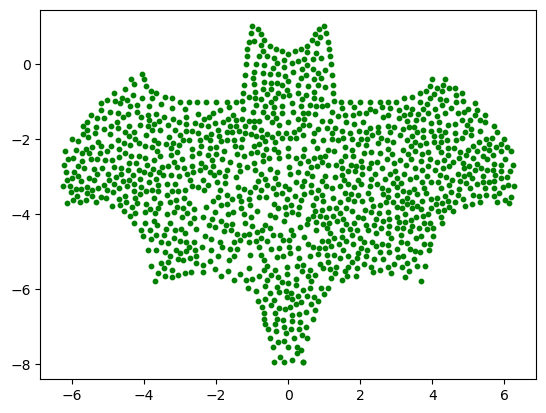

In [10]:
plt.scatter(pts_g[0]['pt_f_c'][:N+cant_pt_cumplidos,0], pts_g[0]['pt_f_c'][:N+cant_pt_cumplidos,1],c="green",s=10)
plt.show()

## Rectas Y Vectores Normales
Muestra de la formación de las rectas

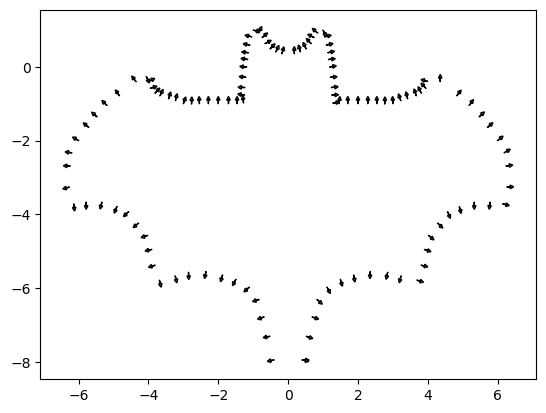

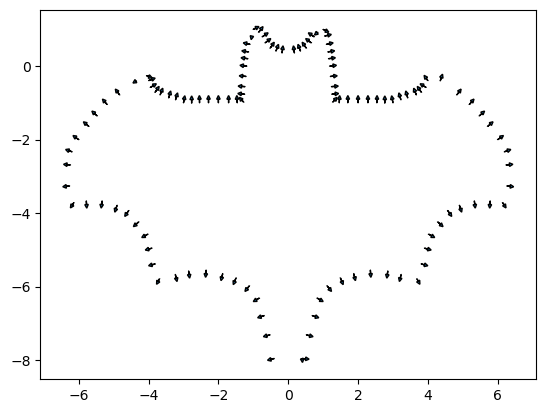

In [18]:
"""
Se calcularán los valores minimos y maximos de los puntos que tiene el poligono
después se procederá a añadirles o restarles un valor con la finalidad
de que se pueda visualizar toda la gráfica
"""
x_min = np.amin( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,0] )
x_max = np.amax( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,0] )
x_max += x_max*0.5
x_min -= x_min*0.5

y_min = np.amin( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,1] )
y_max = np.amax( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,1] )
y_max += y_max*0.5
y_min -= y_min*0.5


#Estos son los vectores directores a las rectas normales, pero no a los puntos
vec_normal_u = np.array(vec_normal,copy=True)
vec_normal_u2 = np.array(vec_normal,copy=True)
vec_normal_u*=0.1
vec_normal_u2*=0.1


#Con esto pasaremos cada uno de los vectores directores hacia afuera de la figura
for pp in range(0,len(rectas_normales)):
    
    #Si el vector normal al hacer crecer la recta termina dentro de la figura, entonces
    #Pasaremos a movernos hacia el otro lado y listo
    x_pr,y_pr = rectas_normales[pp,2] + vec_normal_u[pp,0],rectas_normales[pp,4] + vec_normal_u[pp,1]
    
    if (sh.contains(poly,Point(x_pr,y_pr)))==True:
        vec_normal_u[pp,0] *=-1
        vec_normal_u[pp,1] *=-1
        plt.arrow(rectas_normales[pp,2],rectas_normales[pp,4],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
    else:
        plt.arrow(rectas_normales[pp,2],rectas_normales[pp,4],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
    
    
x_pr,y_pr = rectas_normales[pp,2] + vec_normal_u[pp,0],rectas_normales[pp,4] + vec_normal_u[pp,1]
    

if (sh.contains(poly,Point(x_pr,y_pr)))==True:
    vec_normal_u[pp,0] *=-1
    vec_normal_u[pp,1] *=-1    
    plt.arrow(rectas_normales[pp,3],rectas_normales[pp,5],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
else:
    plt.arrow(rectas_normales[pp,3],rectas_normales[pp,5],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
  

plt.show()








"""
Para calcular los vectores directores normales a los puntos, lo que se hará es:
    1. Sumar los dos vectores normales de las rectas que intersectan en el punto
    2. Se dividiran en dos sus valores y ese será el vector_director ponderado

Para eso usaremos una nueva variable:
    vec_normal_pts que en sus 2 primeros elementos guardara el punto donde inicia
    y en sus ultimos dos elementos guardará el punto en el que termina
"""
vec_normal_pts = np.zeros((N,4),np.float64)

#Esto nos ayudara a encontrar cada vector director para cada punto
#Recordemos que hay una recta menos nada más
for pp in range(0,len(rectas_normales)):
    if pp==0:
        vec_normal_pts[pp,0] = rectas_normales[pp,2]
        vec_normal_pts[pp,1] = rectas_normales[pp,4]
        
        vec_normal_pts[pp,2] = (vec_normal_u[pp,0] + vec_normal_u[len(vec_normal_u)-1,0])/2
        vec_normal_pts[pp,3] = (vec_normal_u[pp,1] + vec_normal_u[len(vec_normal_u)-1,1])/2
        

    elif (pp != 0) :
        vec_normal_pts[pp,0] = rectas_normales[pp,2]
        vec_normal_pts[pp,1] = rectas_normales[pp,4]
        
        vec_normal_pts[pp,2] = (vec_normal_u[pp,0] + vec_normal_u[pp-1,0])/2
        vec_normal_pts[pp,3] = (vec_normal_u[pp,1] + vec_normal_u[pp-1,1])/2
        

vec_normal_pts[pp,0] = rectas_normales[pp,2]
vec_normal_pts[pp,1] = rectas_normales[pp,4]
        
vec_normal_pts[pp,2] = (vec_normal_u[pp-1,0] + vec_normal_u[pp,0])/2
vec_normal_pts[pp,3] = (vec_normal_u[pp-1,1] + vec_normal_u[pp,1])/2
        
vec_normal_pts[N-1,0] = rectas_normales[pp,3]
vec_normal_pts[N-1,1] = rectas_normales[pp,5]
        
vec_normal_pts[N-1,2] = (vec_normal_u[pp-1,0] + vec_normal_u[pp,0])/2
vec_normal_pts[N-1,3] = (vec_normal_u[pp-1,1] + vec_normal_u[pp,1])/2
      

"""
Ahora graficaremos y aparte guardaremos las nuevas direcciones de esas normales
"""
#print(vec_normal_u)
for pp in range(0,len(rectas_normales)+1):
    #Si el vector normal al hacer crecer la recta termina dentro de la figura, entonces
    #Pasaremos a movernos hacia el otro lado y listo
    x_pr, y_pr = vec_normal_pts[pp,0] + vec_normal_pts[pp,2], vec_normal_pts[pp,1] + vec_normal_pts[pp,3]
    
    if (sh.contains(poly,Point(x_pr,y_pr)))==True:
        vec_normal_pts[pp,2] *= -1
        vec_normal_pts[pp,3] *= -1
        plt.arrow(vec_normal_pts[pp,0],vec_normal_pts[pp,1],vec_normal_pts[pp,2],vec_normal_pts[pp,3],head_length = 0.1,head_width=0.1)
    else:
        plt.arrow(vec_normal_pts[pp,0],vec_normal_pts[pp,1],vec_normal_pts[pp,2],vec_normal_pts[pp,3],head_length = 0.1,head_width=0.1)

#plt.scatter(pt[0]['pt_f_c'][])       
plt.show()   



# Vectores normales con optimización

Mandaremos a llamar las funciones para encontrar los vectores normales a cada punto para el batman

C:\Users\andre\AppData\Local\Temp\ipykernel_20400\3744838621.py:455: ComplexWarning: Casting complex values to real discards the imaginary part
  x_final =float( eig_pon[0]*0.001 + pt_c_u[0])
C:\Users\andre\AppData\Local\Temp\ipykernel_20400\3744838621.py:456: ComplexWarning: Casting complex values to real discards the imaginary part
  y_final =float( eig_pon[1]*0.001 + pt_c_u[1])
C:\Users\andre\AppData\Local\Temp\ipykernel_20400\3438147062.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  normal_optimization_vectors[i,:] = normal_metodo_optimizacion(pts_nhd = pts_g[0]['pt_f_c'][:],
C:\Users\andre\AppData\Local\Temp\ipykernel_20400\3744838621.py:471: ComplexWarning: Casting complex values to real discards the imaginary part
  x_final = float(eig_pon[0]*0.001 + pt_c_u[0])
C:\Users\andre\AppData\Local\Temp\ipykernel_20400\3744838621.py:472: ComplexWarning: Casting complex values to real discards the imaginary part
  y_final = float(eig_pon[1]*0.001 + pt_

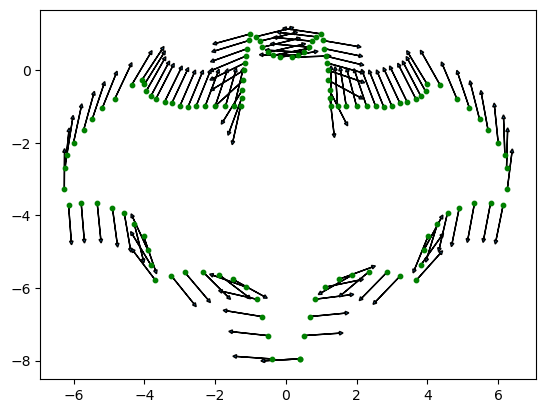

igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
igual
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
dif
igual
igual
igual
igual
igual
igual
igual
igual


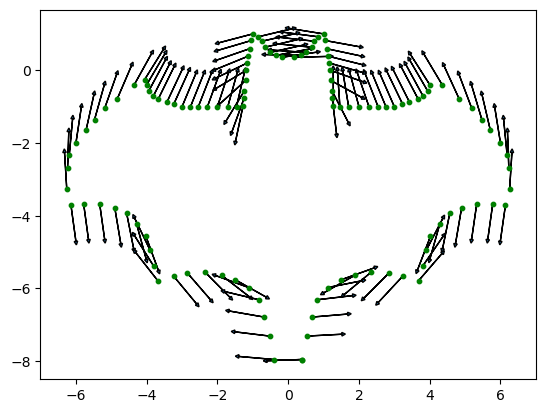

In [32]:
#Necesitamos un array que use los puntos circundantes
#y con esto los mandamos para hacer la suma de matrices
normal_optimization_vectors = np.zeros((N,2),np.float64)

#indice del punto central
i_c = 0

#Indice de los puntos cercanos
for i in range(0,N):
    normal_optimization_vectors[i,:] = normal_metodo_optimizacion(pts_nhd = pts_g[0]['pt_f_c'][:],
                                         pt_c = pts_g[0]['pt_f_c'][i],
                                         f = "Gaussian",
                                         Figura = poly, metodo=1)
    plt.arrow(pts_g[0]['pt_f_c'][i][0],pts_g[0]['pt_f_c'][i][1],normal_optimization_vectors[i][0],normal_optimization_vectors[i][1],head_length = 0.1,head_width=0.1)

    
plt.scatter(pts_g[0]['pt_f_c'][:N,0], pts_g[0]['pt_f_c'][:N,1],c="green",s=10)

plt.show()


#Necesitamos un array que use los puntos circundantes
#y con esto los mandamos para hacer la suma de matrices
normal_optimization_vectors = np.zeros((N,2),np.float64)

#indice del punto central
i_c = 0

#Indice de los puntos cercanos
for i in range(0,N):
    normal_optimization_vectors[i,:] = normal_metodo_optimizacion(pts_nhd = pts_g[0]['pt_f_c'][:],
                                         pt_c = pts_g[0]['pt_f_c'][i],
                                         f = "Gaussian",
                                         Figura = poly, metodo=0)
    plt.arrow(pts_g[0]['pt_f_c'][i][0],pts_g[0]['pt_f_c'][i][1],normal_optimization_vectors[i][0],normal_optimization_vectors[i][1],head_length = 0.1,head_width=0.1)

    
plt.scatter(pts_g[0]['pt_f_c'][:N,0], pts_g[0]['pt_f_c'][:N,1],c="green",s=10)

plt.show()

In [28]:
normal

(-0.8644248450856107, 0.5027620582330354)

# Celdas de pruebas

Intentaremos calcular todos los puntos circundantes de cada uno de los puntos

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

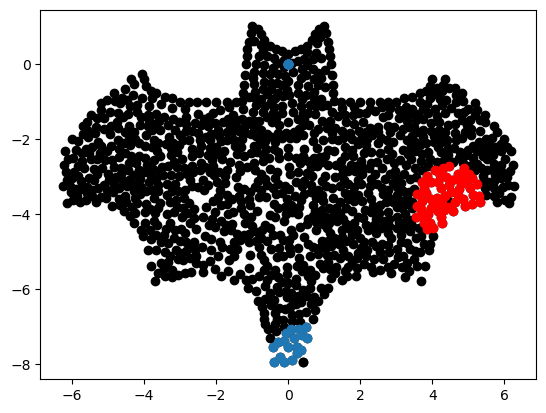

In [90]:
#Circunferencia de la vecindad
h = 1
N_f = N+cant_pt_cumplidos
#Es un arreglo con N_f arreglos de dimensiones (N_f,2)
#Que usaremos para guardar los puntos vecinos
#Se tomara que el arreglo 0 de dimensiones (N_f,2) corresponde al punto 0
#que el arreglo 1 de dimensiones (N_f,2) corresponde al punto 1 y así sucesivamente
pts_veci = np.zeros((N_f,N_f,2),np.float64)

for i in range(0,N_f):
    #print(i)
    indices_arr = pts_vecindad(
        pts_g[0]['pt_f_c'][:,:],
        pts_g[0]['pt_f_c'][i,:],
        h)
    indices_arr_lista = indices_arr.astype(int).flatten().tolist()
    pts_veci[i,:len(indices_arr_lista)] = pts_g[0]['pt_f_c'][indices_arr_lista,:]

plt.scatter(pts_g[0]['pt_f_c'][:,0],pts_g[0]['pt_f_c'][:,1],color='black')
#Imprimamos esos indices

#Con estos metodos convertimos un arreglo de numpy a entero->lista doble ->Una solalista
# arreglo.astype(int).flatten().tolist()
#indices_arr_lista = indices_arr.astype(int).flatten().tolist()
#plt.scatter(pts_g[0]['pt_f_c'][indices_arr_lista,0],pts_g[0]['pt_f_c'][indices_arr_lista,1],color='red')
#plt.scatter(pts_veci[0,:,0],pts_veci[0,:,1])

In [130]:
import math as mt
print(round(N_f/16)*16)
print(N_f)
diferencia = round(N_f/16)
mmmm = range(N_f)
for i in range(0,16):
    startin =i*diferencia + (i>0)
    finalin =(i+1)*diferencia
    print("inicio:",startin, "final", finalin)
    
    if finalin>N_f:
        finalin = N_f-1
    print(mmmm[startin],"--",mmmm[finalin])
    

1248
1245
inicio: 0 final 78
0 -- 78
inicio: 79 final 156
79 -- 156
inicio: 157 final 234
157 -- 234
inicio: 235 final 312
235 -- 312
inicio: 313 final 390
313 -- 390
inicio: 391 final 468
391 -- 468
inicio: 469 final 546
469 -- 546
inicio: 547 final 624
547 -- 624
inicio: 625 final 702
625 -- 702
inicio: 703 final 780
703 -- 780
inicio: 781 final 858
781 -- 858
inicio: 859 final 936
859 -- 936
inicio: 937 final 1014
937 -- 1014
inicio: 1015 final 1092
1015 -- 1092
inicio: 1093 final 1170
1093 -- 1170
inicio: 1171 final 1248
1171 -- 1244


In [103]:
#Vamos a crear dos hilos con algunas iteraciones, para que corran
#distintos datos, y ver como funcionan sus salidas en la terminal

"""Para poder usar threads, se necesitan mandar a llamar las siguientes
Bibliotecas"""
#Obligatoria
import threading as th
from multiprocessing import Process
#Condicionales
import os #Para concer el numero de cores en tu pc

#No necesarias, solo usadas para darle un poco de forma a los formatos
#de salida
import winsound
import time

#Las siguientes bibliotecas son solo para ejecutar la funcion q queremos
import numpy as np
import matplotlib.pyplot as plt
import random

"""
---------------------------------------------------
Apartir de aqui empieza la escritura de Funciones
---------------------------------------------------
"""
taco = time.time()

#Esta es la funcion que se ejecutara en cada hilo
def funcion():
        
        x = np.empty((1000000), float)

        for i in range(0,10):
                for n in range(0,1000000):
                        x[n] = 43
        print("Finalizado hilo")
        

# Para observar la ejecucion debemos de ejecutar en una consola
# y colocamos el main para facilitar todo

if __name__ == '__main__':
        #En esta lista se guardaran los hilos
        hilos = []
        
        cores = os.cpu_count()
        print("Tienes", cores, "cores")

        print("Se crean los hilos")
        #El numero de hilos sera segun el numero de cores q tengamos

        for n in range(cores):

                hilo = Process(target = funcion, args=())
                #Los adicionamos a la lista de procesos
                hilos.append(hilo)

        print("Los hilos empezaran a ejecutarse")
        for hilo in hilos:
                hilo.start()
        
        print("------espera?")

        
        for hilo in hilos:
                hilo.join() #Se bloquea la ejecucion del formato principal
                            #hasta que se acaben de ejecutar los hilos
                print("hilo:", hilo)
        
        print("Regreso a la ejecucion inicial")
        time.sleep(1)

print(time.time() - taco)

for i in range(0,16):
    funcion()

Tienes 16 cores
Se crean los hilos
Los hilos empezaran a ejecutarse
------espera?
hilo: <Process name='Process-65' pid=9020 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-66' pid=8172 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-67' pid=14200 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-68' pid=25148 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-69' pid=7100 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-70' pid=9984 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-71' pid=15288 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-72' pid=9200 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-73' pid=14316 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-74' pid=3612 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-75' pid=17344 parent=20400 stopped exitcode=1>
hilo: <Process name='Process-76' pid=18872 parent=20400 stopped exitcode=1>
hilo: <Proce

KeyboardInterrupt: 

In [10]:
#Prueba de multiplicacion de vectores y vectores transpuestos
#RC
n_vec = np.zeros((2,1))
n_vec[0] = 1
n_vec[1] = 2

n_vec*np.transpose(n_vec)

array([[1., 2.],
       [2., 4.]])

In [11]:
#Matrix 3x3
A = np.array([[0,1],
              [3,2]])

#Eigenvalores 
R_v = scipy.linalg.eigvals(A)

#Eigenvectores
R = np.linalg.eig(A)

#Eigenvectores
eig_1 = R[1][0][0],R[1][1][0]#,R[1][2][0]
#print(eig_1)
eig_2 = R[1][0][1],R[1][1][1]#,R[1][2][1]
#print(eig_2)
#eig_3 = R[1][0][2],R[1][1][2],R[1][2][2]
#print(eig_3)

#De esta manera convirmamos que sean eigenvectore
#e eigenvalores

# eig_val*eig_Vec
print(R_v[0]*np.array(eig_1))
izq_ecuacion = np.round((R_v[0]*np.array(eig_1)).real,5)
print(izq_ecuacion)
#matrix*eig_Vec
x=0
y=0
z=0
for i in range(0,2):
    x += A[0][i]*eig_1[i]
    y += A[1][i]*eig_1[i]
    #z += A[2][i]*eig_1[i]
print(R_v[0] )
print(R)
der_ecuacion = np.round(np.array([x,y]),5)


[ 0.70710678-0.j -0.70710678+0.j]
[ 0.70711 -0.70711]
(-1.0000000000000004+0j)
(array([-1.,  3.]), array([[-0.70710678, -0.31622777],
       [ 0.70710678, -0.9486833 ]]))


In [12]:
if (der_ecuacion == izq_ecuacion).all() == True:
    print("Todos iguales")

Todos iguales


## Arreglo para guardar los puntos

In [78]:
#Es un arreglo con N arreglos de dimensiones (N,2)
arra = np.zeros((N,N,2),np.float64)

#Le ponenmos que no tienen valor todos los puntos
arra[:] = np.nan

arra[1,:1]= 1
arra[0,:]=2

arra[1]

array([[ 1.,  1.],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan,